#Outage Prediction Algorithm
The objective of this project is to model the outage duration using different features as will be discussed in this notebook.

##Importing of Libraries and Data Extraction

### Loading and Characterization of the Data

In [774]:
# Import libraries and mount drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output

import sklearn as sks
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [775]:
# Load the dataset
master_data = pd.read_excel('/content/Major Outage Data - delos Santos, Rhaniel.xlsx', sheet_name='Masterdata')
master_data.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [776]:
# Check the information of the dataset
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBS                      1534 non-null   int64         
 1   YEAR                     1534 non-null   int64         
 2   MONTH                    1525 non-null   float64       
 3   U.S._STATE               1534 non-null   object        
 4   POSTAL.CODE              1534 non-null   object        
 5   NERC.REGION              1534 non-null   object        
 6   CLIMATE.REGION           1528 non-null   object        
 7   ANOMALY.LEVEL            1525 non-null   float64       
 8   CLIMATE.CATEGORY         1525 non-null   object        
 9   OUTAGE.START.DATE        1525 non-null   datetime64[ns]
 10  OUTAGE.START.TIME        1525 non-null   object        
 11  OUTAGE.RESTORATION.DATE  1476 non-null   datetime64[ns]
 12  OUTAGE.RESTORATION.TIME  1476 non-

In [777]:
# Check the shape of the dataframe
master_data.shape

(1534, 54)

In [778]:
# Check summary statistics of the dataset
master_data.describe()

,OBS,YEAR,MONTH,ANOMALY.LEVEL,OUTAGE.DURATION,RES.PRICE,COM.PRICE,IND.PRICE,TOTAL.PRICE,RES.SALES,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
count,1534.000000,1534.000000,1525.000000,1525.000000,1476.000000,1512.000000,1512.000000,1512.000000,1512.000000,1.512000e+03,...,1534.000000,1534.000000,1534.000000,1524.000000,1524.000000,1534.000000,1534.000000,1534.000000,1534.000000,1534.000000
mean,767.500000,2010.119296,6.234754,-0.096852,2625.398374,11.968373,10.135053,7.341468,10.117851,4.340337e+06,...,80.967112,9.545267,2594.174967,1558.041142,39.473491,8.604348,1.117608,90.158521,9.841405,2.911191
std,442.971971,3.822306,3.254510,0.739957,5942.483307,3.088631,2.824150,2.473902,2.905234,3.377434e+06,...,11.900026,5.240315,1083.200091,313.149226,30.890074,11.134773,0.995424,10.519099,10.518892,2.115077
min,1.000000,2000.000000,1.000000,-1.600000,0.000000,5.650000,4.700000,3.200000,4.700000,1.444170e+05,...,38.660000,0.000000,1232.600000,988.700000,0.400000,0.050000,0.000000,58.459995,0.240151,0.240151
25%,384.250000,2008.000000,4.000000,-0.500000,102.250000,9.540000,8.017500,5.697500,7.957500,2.052570e+06,...,74.570000,5.220000,2016.300000,1307.800000,15.200000,3.350000,0.590000,86.382550,2.742036,1.730658
50%,767.500000,2011.000000,6.000000,-0.300000,701.000000,11.460000,9.465000,6.710000,9.410000,3.441587e+06,...,84.050000,9.080000,2380.000000,1528.600000,29.500000,5.280000,0.970000,95.164177,4.835823,2.090873
75%,1150.750000,2013.000000,9.000000,0.300000,2880.000000,13.900000,11.340000,8.590000,11.740000,6.023744e+06,...,89.810000,12.020000,2847.425000,1732.200000,54.600000,8.680000,1.460000,97.258336,13.617450,3.645862
max,1534.000000,2016.000000,12.000000,2.300000,108653.000000,34.580000,32.140000,27.850000,31.290000,1.862066e+07,...,100.000000,40.250000,9856.500000,2220.700000,142.300000,100.000000,6.210000,99.759849,41.540005,10.294118


## Data Cleaning

In [779]:
# Rename columns - replace dots by underscores
def replace_dot(df):
    df.columns = df.columns.str.replace('.', '_')

replace_dot(master_data)
master_data.columns

# Replace NA entries in the dataframe with NaN
def replace_NA(df):
  col_list = df.columns
  for col in col_list:
    df[col] = df[col].replace('NA', np.nan)

replace_NA(master_data)

# Check the information of the dataframe again
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBS                      1534 non-null   int64         
 1   YEAR                     1534 non-null   int64         
 2   MONTH                    1525 non-null   float64       
 3   U_S__STATE               1534 non-null   object        
 4   POSTAL_CODE              1534 non-null   object        
 5   NERC_REGION              1534 non-null   object        
 6   CLIMATE_REGION           1528 non-null   object        
 7   ANOMALY_LEVEL            1525 non-null   float64       
 8   CLIMATE_CATEGORY         1525 non-null   object        
 9   OUTAGE_START_DATE        1525 non-null   datetime64[ns]
 10  OUTAGE_START_TIME        1525 non-null   object        
 11  OUTAGE_RESTORATION_DATE  1476 non-null   datetime64[ns]
 12  OUTAGE_RESTORATION_TIME  1476 non-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [780]:
# Reset the index and delete the OBS column
master_data.drop('OBS', inplace=True, axis=1)
master_data.reset_index(inplace=True)
master_data.head()

,index,YEAR,MONTH,U_S__STATE,POSTAL_CODE,NERC_REGION,CLIMATE_REGION,ANOMALY_LEVEL,CLIMATE_CATEGORY,OUTAGE_START_DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,1,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [781]:
# Filter data entries based on:
master_data = master_data[master_data['CAUSE_CATEGORY'] == 'severe weather']  ## Outages caused by severe weather (CAUSE_CATEGORY = severe weather)
master_data = master_data[master_data['OUTAGE_DURATION'] > 0] ## Outages where outage duration is greater than 0

# Check the new shape and information of the dataframe
master_data.shape
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 0 to 1519
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    741 non-null    int64         
 1   YEAR                     741 non-null    int64         
 2   MONTH                    741 non-null    float64       
 3   U_S__STATE               741 non-null    object        
 4   POSTAL_CODE              741 non-null    object        
 5   NERC_REGION              741 non-null    object        
 6   CLIMATE_REGION           737 non-null    object        
 7   ANOMALY_LEVEL            741 non-null    float64       
 8   CLIMATE_CATEGORY         741 non-null    object        
 9   OUTAGE_START_DATE        741 non-null    datetime64[ns]
 10  OUTAGE_START_TIME        741 non-null    object        
 11  OUTAGE_RESTORATION_DATE  741 non-null    datetime64[ns]
 12  OUTAGE_RESTORATION_TIME  741 non-nu

## Statistical Analysis

### Missing Values

In [782]:
# From the filtered dataset, columns CAUSE_CATEGORY_DETAIL, CLIMATE_REGION, HURRICANES_NAMES, RES_PRICE, COM_PRICE, IND_PRICE, TOTAL_PRICE, RES_SALES, COM_SALES, IND_SALES,
# TOTAL_SALES, RES_PERCEN, COM_PERCEN, IND_PERCEN, POPDEN_UC, and POPDEN_RURAL have missing values

# Create a separate list for numerical and categorical variables with missing values

# Create list for numerical variables
missing_num_var = ['RES_PRICE', 'COM_PRICE', 'IND_PRICE', 'TOTAL_PRICE', 'RES_SALES', 'COM_SALES', 'IND_SALES', 'TOTAL_SALES', 'RES_PERCEN', 'COM_PERCEN', 'IND_PERCEN', 'POPDEN_UC', 'POPDEN_RURAL']

# Create list for categorical variables
missing_cat_var = ['CLIMATE_REGION', 'CAUSE_CATEGORY_DETAIL', 'HURRICANE_NAMES']


#### Numerical Variables

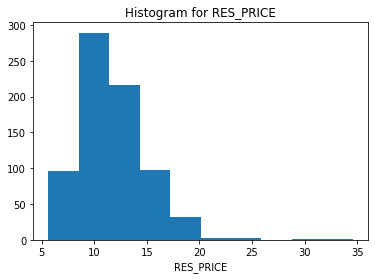

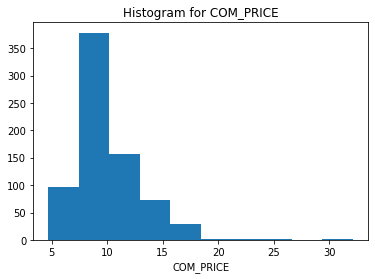

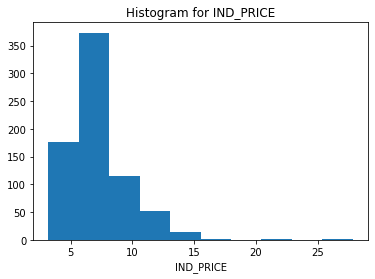

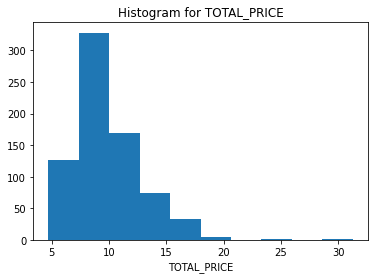

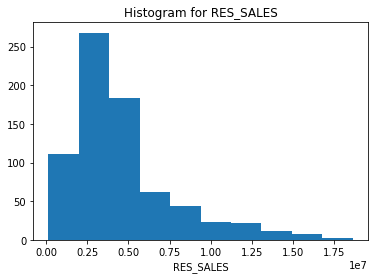

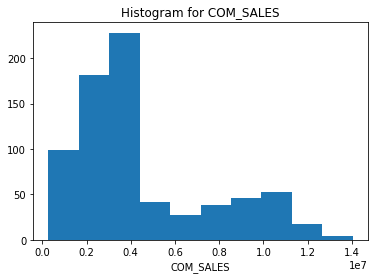

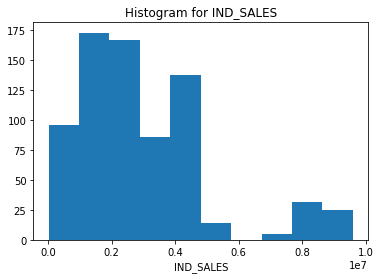

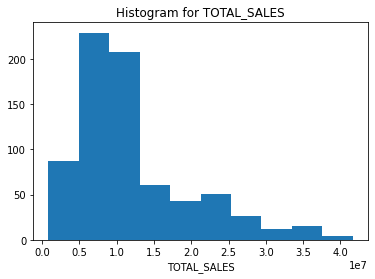

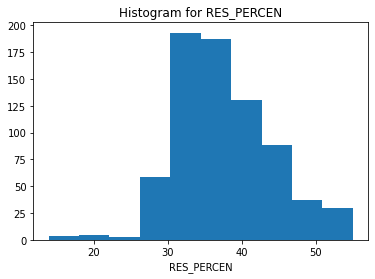

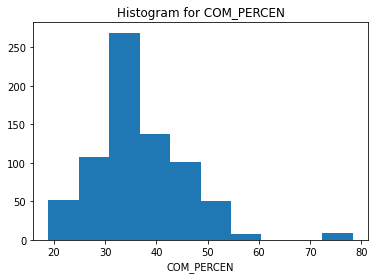

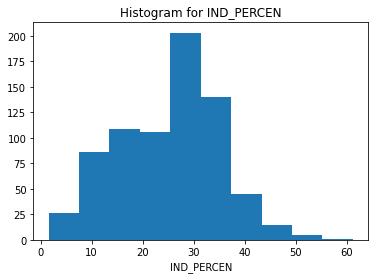

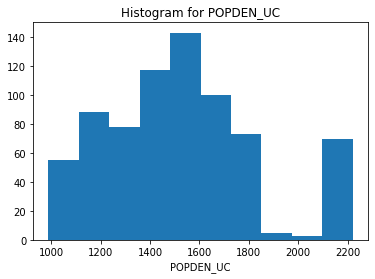

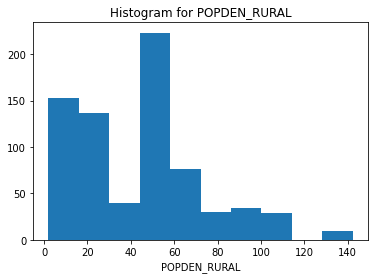

In [783]:
# Create visualizations to understand the nature of columns with missing values

# Create a histogram for the numerical variables
for col in missing_num_var:
  plt.hist(master_data[col])
  plt.xlabel(col)
  plt.title(f'Histogram for {col}')
  plt.show()

In [784]:
# Determine the outliers for columns with missing values
def det_outliers_missing(df, missing_df):
  for col in missing_df:
    q = df[col].quantile(0.99)
    df[df[col] < q]

    q_low = df[col].quantile(0.01)
    q_hi = df[col].quantile(0.99)

    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

    return df_filtered

filtered_data = det_outliers_missing(master_data, missing_num_var)
filtered_data

,index,YEAR,MONTH,U_S__STATE,POSTAL_CODE,NERC_REGION,CLIMATE_REGION,ANOMALY_LEVEL,CLIMATE_CATEGORY,OUTAGE_START_DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,0,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
2,2,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
3,3,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
4,4,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
5,5,2010,11.0,Minnesota,MN,MRO,East North Central,-1.4,cold,2010-11-13,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1498,2016,3.0,Colorado,CO,WECC,Southwest,1.6,warm,2016-03-23,...,86.15,9.29,2836.1,1732.2,6.8,1.47,0.26,99.565777,0.434223,0.434223
1504,1504,2006,10.0,Colorado,CO,MRO,Southwest,0.7,warm,2006-10-26,...,86.15,9.29,2836.1,1732.2,6.8,1.47,0.26,99.565777,0.434223,0.434223
1509,1509,2015,4.0,Kansas,KS,SPP,South,0.7,warm,2015-04-03,...,74.20,24.03,2176.5,1983.0,9.1,1.19,0.42,99.369212,0.632004,0.632004
1510,1510,2007,12.0,Kansas,KS,MRO,South,-1.3,cold,2007-12-11,...,74.20,24.03,2176.5,1983.0,9.1,1.19,0.42,99.369212,0.632004,0.632004


In [785]:
# Check again the information of the filtered_data
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 1514
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    720 non-null    int64         
 1   YEAR                     720 non-null    int64         
 2   MONTH                    720 non-null    float64       
 3   U_S__STATE               720 non-null    object        
 4   POSTAL_CODE              720 non-null    object        
 5   NERC_REGION              720 non-null    object        
 6   CLIMATE_REGION           720 non-null    object        
 7   ANOMALY_LEVEL            720 non-null    float64       
 8   CLIMATE_CATEGORY         720 non-null    object        
 9   OUTAGE_START_DATE        720 non-null    datetime64[ns]
 10  OUTAGE_START_TIME        720 non-null    object        
 11  OUTAGE_RESTORATION_DATE  720 non-null    datetime64[ns]
 12  OUTAGE_RESTORATION_TIME  720 non-nu

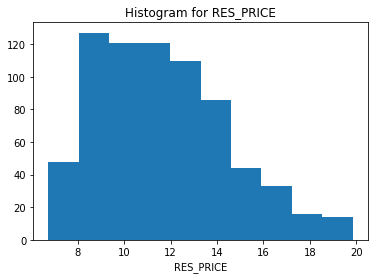

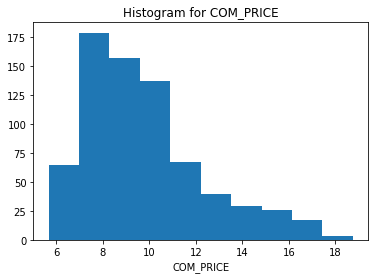

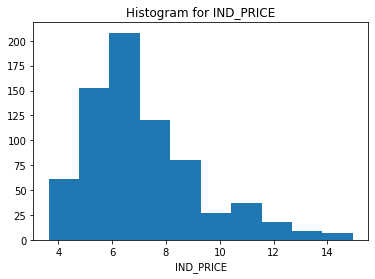

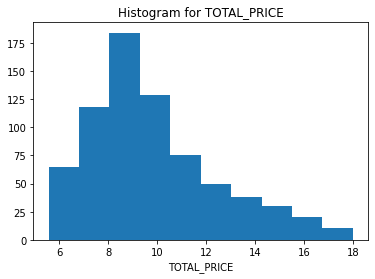

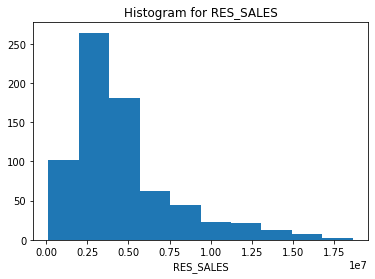

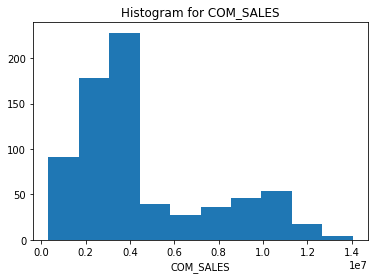

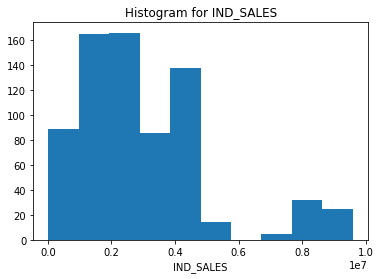

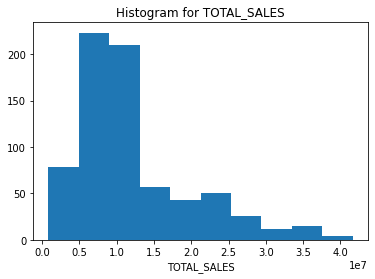

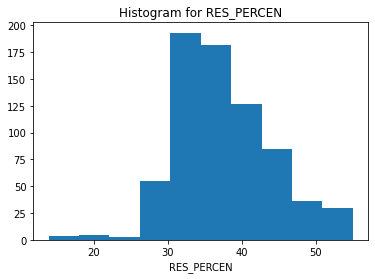

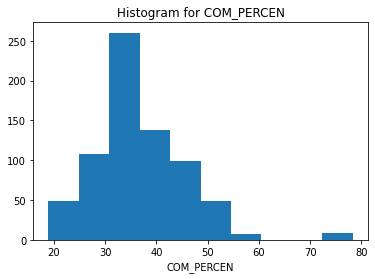

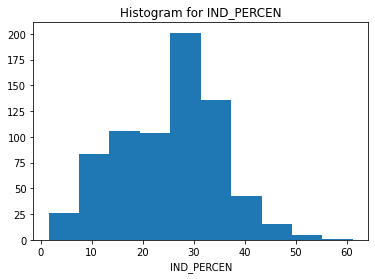

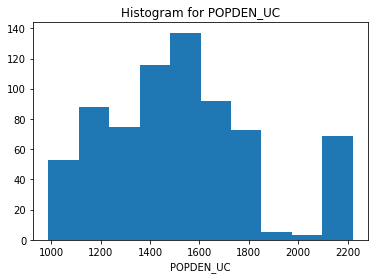

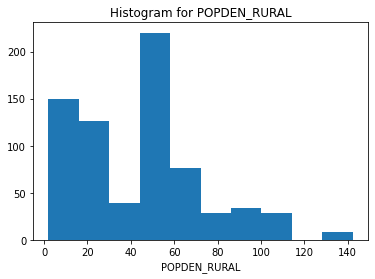

In [786]:
# Check again the distribution of numerical variables with missing values
for col in missing_num_var:
  plt.hist(det_outliers_missing(master_data, missing_num_var)[col])
  plt.xlabel(col)
  plt.title(f'Histogram for {col}')
  plt.show()


In [787]:
# Determine the mean and median of the filtered numerical variables
for col in missing_num_var:
  num_col_mean = det_outliers_missing(master_data, missing_num_var)[col].mean()
  num_col_median = det_outliers_missing(master_data, missing_num_var)[col].median()

  print(f"The mean of {col} is {num_col_mean}")
  print(f"The median of {col} is {num_col_median}")
  print(' ')

The mean of RES_PRICE is 11.643819444444443
The median of RES_PRICE is 11.26
 
The mean of COM_PRICE is 9.809416666666667
The median of COM_PRICE is 9.335
 
The mean of IND_PRICE is 7.177027777777778
The median of IND_PRICE is 6.6850000000000005
 
The mean of TOTAL_PRICE is 9.836458333333333
The median of TOTAL_PRICE is 9.21
 
The mean of RES_SALES is 4637430.605555556
The median of RES_SALES is 3756376.5
 
The mean of COM_SALES is 4521286.259722223
The median of COM_SALES is 3606053.0
 
The mean of IND_SALES is 3010204.6180555555
The median of IND_SALES is 2596980.0
 
The mean of TOTAL_SALES is 12208321.725
The median of TOTAL_SALES is 10273514.5
 
The mean of RES_PERCEN is 37.54640359882455
The median of RES_PERCEN is 36.7672119592148
 
The mean of COM_PERCEN is 36.879778846372304
The median of COM_PERCEN is 35.46069122457505
 
The mean of IND_PERCEN is 25.22373155333363
The median of IND_PERCEN is 26.8579670206691
 
The mean of POPDEN_UC is 1508.6696202531648
The median of POPDEN_UC

In [788]:
# Determine the mean and median of the numerical variables
for col in missing_num_var:
  num_col_mean = master_data[col].mean()
  num_col_median = master_data[col].median()

  print(f"The mean of {col} is {num_col_mean}")
  print(f"The median of {col} is {num_col_median}")
  print(' ')

The mean of RES_PRICE is 11.720665760869565
The median of RES_PRICE is 11.26
 
The mean of COM_PRICE is 9.888614130434783
The median of COM_PRICE is 9.335
 
The mean of IND_PRICE is 7.241182065217392
The median of IND_PRICE is 6.6850000000000005
 
The mean of TOTAL_PRICE is 9.911616847826087
The median of TOTAL_PRICE is 9.21
 
The mean of RES_SALES is 4582263.002717392
The median of RES_SALES is 3678747.0
 
The mean of COM_SALES is 4465702.4619565215
The median of COM_SALES is 3572580.5
 
The mean of IND_SALES is 2967175.7663043477
The median of IND_SALES is 2528661.0
 
The mean of TOTAL_SALES is 12055018.661684783
The median of TOTAL_SALES is 10058433.5
 
The mean of RES_PERCEN is 37.559868806753705
The median of RES_PERCEN is 36.86596545115305
 
The mean of COM_PERCEN is 36.843768976167276
The median of COM_PERCEN is 35.4373070338883
 
The mean of IND_PERCEN is 25.2335045296671
The median of IND_PERCEN is 26.847448098200452
 
The mean of POPDEN_UC is 1508.9401639344262
The median of 

In [789]:
# Impute missing values with median
master_data = filtered_data
for col in missing_num_var:
  master_data[col].fillna(master_data[col].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

#### Categorical Variables

In [790]:
# Delete the HURRICANE_NAMES column
master_data.drop(columns=['HURRICANE_NAMES'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [791]:
# Check the information
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 1514
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    720 non-null    int64         
 1   YEAR                     720 non-null    int64         
 2   MONTH                    720 non-null    float64       
 3   U_S__STATE               720 non-null    object        
 4   POSTAL_CODE              720 non-null    object        
 5   NERC_REGION              720 non-null    object        
 6   CLIMATE_REGION           720 non-null    object        
 7   ANOMALY_LEVEL            720 non-null    float64       
 8   CLIMATE_CATEGORY         720 non-null    object        
 9   OUTAGE_START_DATE        720 non-null    datetime64[ns]
 10  OUTAGE_START_TIME        720 non-null    object        
 11  OUTAGE_RESTORATION_DATE  720 non-null    datetime64[ns]
 12  OUTAGE_RESTORATION_TIME  720 non-nu

In [792]:
# Sort the dataframe according to OUTAGE_START_DATE
master_data.sort_values(by='OUTAGE_START_DATE', ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [793]:
# Forward fill the CAUSE_CATEGORY_DETAILS column
master_data['CAUSE_CATEGORY_DETAIL'].fillna(method='ffill', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### The Rest of the Variables

In [794]:
# Select the numerical and categorical variables
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

cat_columns = cat_selector(master_data)
num_columns = num_selector(master_data)

#### Numerical Variables

In [795]:
# Determine the outliers for columns with missing values
def det_outliers(df, num_df):
  for col in num_df:
    q = df[col].quantile(0.99)
    df[df[col] < q]

    q_low = df[col].quantile(0.01)
    q_hi = df[col].quantile(0.99)

    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

    return df_filtered

master_data = det_outliers(master_data, num_columns)
master_data

,index,YEAR,MONTH,U_S__STATE,POSTAL_CODE,NERC_REGION,CLIMATE_REGION,ANOMALY_LEVEL,CLIMATE_CATEGORY,OUTAGE_START_DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
810,810,2000,1.0,South Carolina,SC,SERC,Southeast,-1.6,cold,2000-01-23,...,66.33,10.55,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923
812,812,2000,1.0,South Carolina,SC,SERC,Southeast,-1.6,cold,2000-01-29,...,66.33,10.55,1288.1,1117.1,56.3,7.92,1.45,93.881949,6.121174,3.322923
187,187,2000,5.0,Texas,TX,TRE,South,-0.7,cold,2000-05-02,...,84.70,9.35,2435.3,1539.9,15.2,3.35,0.58,97.258336,2.742036,2.090873
731,731,2000,5.0,North Carolina,NC,SERC,Southeast,-0.7,cold,2000-05-25,...,66.09,11.21,1367.2,1043.7,73.5,9.48,2.11,90.336127,9.663873,7.528940
504,504,2000,6.0,Arizona,AZ,WECC,Southwest,-0.7,cold,2000-06-14,...,89.81,9.74,2625.4,1669.0,5.8,1.92,0.33,99.652601,0.347399,0.347399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,1430,2015,12.0,Oklahoma,OK,SPP,South,2.3,warm,2015-12-31,...,66.24,20.46,1901.7,1635.8,18.8,1.90,0.68,98.134451,1.865549,1.865549
786,786,2016,1.0,New Jersey,NJ,RFC,Northeast,2.2,warm,2016-01-23,...,94.68,2.44,2851.2,1446.5,105.5,39.70,2.01,84.305858,15.682678,4.998280
77,77,2016,2.0,Michigan,MI,RFC,East North Central,2.0,warm,2016-02-19,...,74.57,8.19,2034.1,1390.4,47.5,6.41,1.03,58.459995,41.540005,2.068987
283,283,2016,4.0,Texas,TX,TRE,South,1.1,warm,2016-04-18,...,84.70,9.35,2435.3,1539.9,15.2,3.35,0.58,97.258336,2.742036,2.090873


## Exploratory Data Analysis

## Machine Learning Modeling

### Data Pre-Processing

In [796]:
# Define X and y
master_data.drop(columns=['OUTAGE_START_DATE', 'OUTAGE_RESTORATION_DATE'], inplace=True)
X = master_data.drop(columns=['OUTAGE_DURATION'])
y = master_data['OUTAGE_DURATION']

# Split the dataset
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [797]:
# Create feature_columns
feature_columns = []
for feature_name in cat_columns:
  vocabulary = master_data[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in num_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.int64))

print(feature_columns)

[VocabularyListCategoricalColumn(key='U_S__STATE', vocabulary_list=('South Carolina', 'Texas', 'North Carolina', 'Arizona', 'Illinois', 'Alabama', 'Michigan', 'California', 'Connecticut', 'Virginia', 'Pennsylvania', 'New York', 'Wisconsin', 'Ohio', 'Maryland', 'District of Columbia', 'Massachusetts', 'Georgia', 'Florida', 'Oklahoma', 'Louisiana', 'Nebraska', 'Indiana', 'Arkansas', 'Minnesota', 'Maine', 'Washington', 'New Jersey', 'Oregon', 'Iowa', 'Utah', 'Missouri', 'Kentucky', 'Tennessee', 'Wyoming', 'West Virginia', 'New Hampshire', 'Delaware'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='POSTAL_CODE', vocabulary_list=('SC', 'TX', 'NC', 'AZ', 'IL', 'AL', 'MI', 'CA', 'CT', 'VA', 'PA', 'NY', 'WI', 'OH', 'MD', 'DC', 'MA', 'GA', 'FL', 'OK', 'LA', 'NE', 'IN', 'AR', 'MN', 'ME', 'WA', 'NJ', 'OR', 'IA', 'UT', 'MO', 'KY', 'TN', 'WY', 'WV', 'NH', 'DE'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='N

In [798]:
# Create an input function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(master_data, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
test_input_fn = make_input_fn(master_data, y_test, num_epochs=1, shuffle=False)

In [799]:
# Encode variables to be able to be used in feature importance determination

# Select columns
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

cat_columns_train = cat_selector(X_train)
cat_columns_test = cat_selector(X_test)
num_columns_train = num_selector(X_train)
num_columns_test = num_selector(X_test)

cat_data_train = X_train[cat_columns_train]
cat_data_test = X_test[cat_columns_test]
num_data_train = X_train[num_columns_train]
num_data_test = X_test[num_columns_test]

# Instantiate OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the categorical values to the ohe
ohe_train = ohe.fit_transform(cat_data_train)
ohe_test = ohe.transform(cat_data_test)

# Instantiate Standard Scaler
scaler = StandardScaler()

# Fit the scaler
train_scale = scaler.fit_transform(num_data_train)
test_scale = scaler.transform(num_data_test)

# Make a pipeline
pipe = Pipeline(
    steps=(['OneHotEncoder', ohe], ['Standard Scaler', scaler])
)

# Make a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", pipe, num_selector),
        ("cat", pipe, cat_selector),
    ]
)

# Fit with the Xtrain
X_train = pd.DataFrame(preprocessor.fit_transform(X_train))

# Fit transformer with the Xtest
X_test = pd.DataFrame(preprocessor.transform(X_test))

In [800]:
# Determine feature importance
from sklearn.ensemble import RandomForestClassifier as RClf

model = RClf(n_estimators = 100)
model.fit(X_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]

print('Feature Ranking:')

for f in range(X.shape[1]):
	print('%d. features %d (%f)'% (f+1, indices[f], importances[indices[f]]))

Feature Ranking:
1. features 8704 (0.002926)
2. features 8550 (0.002846)
3. features 8414 (0.002594)
4. features 8713 (0.002060)
5. features 8642 (0.002014)
6. features 8250 (0.001694)
7. features 8685 (0.001640)
8. features 8398 (0.001604)
9. features 550 (0.001602)
10. features 8655 (0.001562)
11. features 8703 (0.001555)
12. features 8249 (0.001506)
13. features 8618 (0.001494)
14. features 8299 (0.001468)
15. features 8595 (0.001450)
16. features 8698 (0.001444)
17. features 8430 (0.001431)
18. features 8603 (0.001423)
19. features 8235 (0.001336)
20. features 8667 (0.001322)
21. features 551 (0.001233)
22. features 549 (0.001192)
23. features 8319 (0.001166)
24. features 565 (0.001125)
25. features 8492 (0.001105)
26. features 8516 (0.001075)
27. features 8692 (0.001068)
28. features 8475 (0.001033)
29. features 544 (0.001019)
30. features 545 (0.001007)
31. features 8381 (0.000966)
32. features 8308 (0.000957)
33. features 567 (0.000949)
34. features 553 (0.000944)
35. features 8

### Modeling

#### Linear Regression

In [801]:
# Create a linear estimator
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfeva62q6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [802]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

TypeError: ignored